In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf 
import os 
import numpy as np  
from google.colab import drive

SEED= 10714338
tf.random.set_seed(SEED)

cwd= os.getcwd() #get current working directory 

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.applications.vgg16 import preprocess_input 

import sys
import os
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k

apply_data_augmentation  = True

if  apply_data_augmentation:
  train_datagen = ImageDataGenerator(             #this data augmentation is gonna modify the images at each epoch 
  width_shift_range = 0.2, 
  height_shift_range = 0.2,
  vertical_flip=True,
  shear_range = 0.2,
  horizontal_flip=True,
  rotation_range=10,
  fill_mode='constant',
  cval=0,
  rescale=1/255,   
  preprocessing_function=preprocess_input)
  
else:
  train_datagen = ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)
test_datagen= ImageDataGenerator(rescale=1/255,preprocessing_function=preprocess_input)


In [12]:
#now I need to get the test images and associate them to the label contained in the json file 
import pandas as pd
import json
import sklearn

json_path=os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset')

with open(os.path.join(json_path,"train_gt.json")) as j:
  tmp = json.load(j)

train_df = pd.DataFrame(tmp.items())
train_df.rename(columns = {0:'filename', 1:'class'}, inplace = True)
train_df["class"] = train_df["class"].astype(str)

train_df_shuffled=sklearn.utils.shuffle(train_df) #here we could divide the dataset in training and validation

training_df= train_df_shuffled[614:]
validation_df= train_df_shuffled[:614]

print(validation_df,training_df)

       filename class
4325  13372.jpg     2
258   16933.jpg     0
3321  14919.jpg     1
4129  11686.jpg     2
5085  16578.jpg     2
...         ...   ...
1773  16914.jpg     0
3136  12205.jpg     1
2403  12933.jpg     1
3841  10613.jpg     2
84    17113.jpg     0

[614 rows x 2 columns]        filename class
4264  10200.jpg     2
4171  15008.jpg     2
5063  13312.jpg     2
129   13835.jpg     0
4216  12764.jpg     2
...         ...   ...
1341  15506.jpg     0
5427  14716.jpg     2
2983  15982.jpg     1
396   13689.jpg     0
1404  12105.jpg     0

[5000 rows x 2 columns]


In [13]:
#Let's create the generators 

directory_training =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','training')


bs = 16

train_generator=train_datagen.flow_from_dataframe(
dataframe=training_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,

shuffle=True,
target_size=(224, 224),
class_mode="categorical",
)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=validation_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
target_size=(224, 224),
class_mode="categorical",
)

Found 5000 validated image filenames belonging to 3 classes.
Found 614 validated image filenames belonging to 3 classes.


In [14]:
num_classes=3
img_h=224
img_w=224


train_dataset= tf.data.Dataset.from_generator(lambda:train_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes])) 

train_dataset=train_dataset.repeat()

validation_dataset= tf.data.Dataset.from_generator(lambda:valid_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes]))


validation_dataset=validation_dataset.repeat()


[]

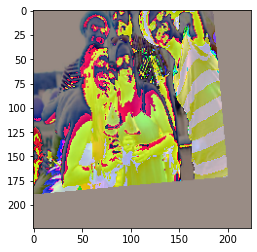

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

iterator= iter(train_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

[]

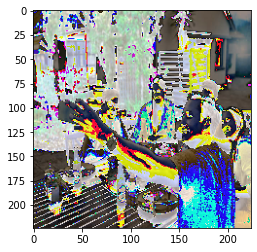

In [10]:
%matplotlib inline

iterator= iter(validation_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

In [21]:
from tensorflow.keras.models import Model
DenseNet_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = tf.keras.layers.AveragePooling2D(pool_size=(3,3), name='avg_pool')(DenseNet_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu', name='dense_post_pool')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(3, activation='softmax', name='predictions')(x)
model = Model(DenseNet_model.input, output)
model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________

In [22]:
loss= tf.keras.losses.CategoricalCrossentropy()

lr= 1e-4

optimizer= tf.keras.optimizers.Adam(learning_rate=lr)

metrics=['accuracy']

model.compile(optimizer=optimizer,loss=loss,metrics=metrics )

In [23]:
#lets do early stopping callback 


callbacks=[]

es_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,patience = 10) 
callbacks.append(es_callback)
    
test_dir =os.path.join(cwd,'drive','My Drive')

#tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
#                                             profile_batch=0,
#                                             histogram_freq=1)  # if 1 shows weights histograms
#callbacks.append(tb_callback)

model.fit(x=train_dataset, 
          epochs=100,  #max number of epoch 
          steps_per_epoch=len(train_generator),
          validation_data= validation_dataset, 
          validation_steps=len(valid_generator),
          callbacks=callbacks )

Epoch 1/100
313/313 [==============================] - 1051s 3s/step - loss: 0.9296 - accuracy: 0.6128 - val_loss: 0.6105 - val_accuracy: 0.7199
Epoch 2/100
313/313 [==============================] - 127s 406ms/step - loss: 0.5182 - accuracy: 0.7702 - val_loss: 0.3835 - val_accuracy: 0.8388
Epoch 3/100
313/313 [==============================] - 126s 401ms/step - loss: 0.4251 - accuracy: 0.8164 - val_loss: 0.3557 - val_accuracy: 0.8762
Epoch 4/100
313/313 [==============================] - 125s 401ms/step - loss: 0.3581 - accuracy: 0.8542 - val_loss: 0.3972 - val_accuracy: 0.8355
Epoch 5/100
313/313 [==============================] - 125s 400ms/step - loss: 0.3084 - accuracy: 0.8792 - val_loss: 0.2705 - val_accuracy: 0.8925
Epoch 6/100
313/313 [==============================] - 126s 403ms/step - loss: 0.2873 - accuracy: 0.8816 - val_loss: 0.2690 - val_accuracy: 0.8990
Epoch 7/100
313/313 [==============================] - 126s 402ms/step - loss: 0.2623 - accuracy: 0.9004 - val_loss: 0.2

In [26]:
test_dir =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','test')

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict(test_gen, len(test_gen), verbose=1)


from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, '/content/drive/My Drive')

Found 450 images belonging to 1 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
450/450 [==============================] - 77s 171ms/step
